## DataLab Cup 4: Recommender Systems
- Team name: 瑜旋學姊教我DL
- Team members:
    - 王興彥 112062531
    - 邱仁緯 112062559
    - 林沁璿 112062632

### Environment Setting

In [1]:
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

import numpy as np
import pandas as pd
from tqdm import tqdm

from evaluation.environment import TrainingEnvironment, TestingEnvironment

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [3]:
# Official hyperparameters for this competition (do not modify)
N_TRAIN_USERS = 1000
N_TEST_USERS = 2000
N_ITEMS = 209527
HORIZON = 2000
TEST_EPISODES = 5
SLATE_SIZE = 5

### Dataset

In [4]:
# Dataset paths
USER_DATA = os.path.join('dataset', 'user_data.json')
ITEM_DATA = os.path.join('dataset', 'item_data.json')

# Output file path
OUTPUT_PATH = os.path.join('output', 'output.csv')

In [5]:
df_user = pd.read_json(USER_DATA, lines=True)
# df_user

In [6]:
df_item = pd.read_json(ITEM_DATA, lines=True)
# df_item

In [7]:
M_USERS = 2000
N_ITEMS = 209527
SEED = 0
tf.random.set_seed(SEED)

In [8]:
# df_ratings = pd.DataFrame(columns=['user_id', 'item_id', 'rating'])

# ratings_data = []
# for i in range(N_TRAIN_USERS):
#     for item_id in df_user['history'][i][:3]:
#         ratings_data.append({'user_id': i, 'item_id': item_id, 'rating': 5.0})

# df_ratings = pd.DataFrame(ratings_data)

df_ratings = pd.read_csv('./dataset/ratings_pos.csv')
# df_ratings

### Recommender Model

In [9]:
class FunkSVDRecommender(tf.keras.Model):
    '''
    Simplified Funk-SVD recommender model
    '''
    def __init__(self, m_users: int, n_items: int, embedding_size: int, learning_rate: float):
        '''
        Constructor of the model
        '''
        super().__init__()
        self.m = m_users
        self.n = n_items
        self.k = embedding_size
        self.lr = learning_rate

        # user embeddings P
        self.P = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.m, self.k)))

        # item embeddings Q
        self.Q = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.n, self.k)))

        # optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate=self.lr)

    @tf.function
    def call(self, user_ids: tf.Tensor, item_ids: tf.Tensor) -> tf.Tensor:
        '''
        Forward pass used in training and validating
        '''
        # dot product the user and item embeddings corresponding to the observed interaction pairs to produce predictions
        y_pred = tf.reduce_sum(tf.gather(self.P, indices=user_ids) * tf.gather(self.Q, indices=item_ids), axis=1)

        return y_pred

    @tf.function
    def compute_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        '''
        Compute the MSE loss of the model
        '''
        loss = tf.losses.mean_squared_error(y_true, y_pred)

        return loss

    @tf.function
    def train_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Train the model with one batch
        data: batched user-item interactions
        each record in data is in the format ['user_id', 'item_id', 'rating']
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # slate = self.eval_predict_onestep(user_ids)
        # print(slate)
        # compute loss
        with tf.GradientTape() as tape:
            y_pred = self(user_ids, item_ids)
            loss = self.compute_loss(y_true, y_pred)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

    @tf.function
    def val_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Validate the model with one batch
        data: batched user-item interactions
        each record in data is in the format ['user_id', 'item_id', 'rating']
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        y_pred = self(user_ids, item_ids)
        loss = self.compute_loss(y_true, y_pred)

        return loss

    @tf.function
    def eval_predict_onestep(self, query: tf.Tensor) -> tf.Tensor:
        '''
        Retrieve and return the MovieIDs of the 5 recommended movies given a query
        You should return a tf.Tensor with shape=(5,)
        query will be a tf.Tensor with shape=(1,) and dtype=tf.int64
        query is the UserID of the query
        '''
        # dot product the selected user and all item embeddings to produce predictions
        user_id = tf.cast(query, tf.int32)
        y_pred = tf.reduce_sum(tf.gather(self.P, user_id) * self.Q, axis=1)

        # select the top 5 items with highest scores in y_pred
        y_top_5 = tf.math.top_k(y_pred, k=5).indices

        return y_top_5

### Split datasets

In [10]:
# let interactions with rating >= 3 be positive interactions
POSITIVE_THRESHOLD = 3

# each per-user validation set should contain at least 3 positive interactions
POSITIVE_PER_USER = 4

train_dataframes = []
val_dataframes = []
# ['user_id', 'item_id', 'rating']
for i in tqdm(range(N_TRAIN_USERS)):
    user_all = df_ratings[df_ratings['user_id'] == i]
    user_positive = user_all[user_all['rating'] >= POSITIVE_THRESHOLD]

    # check if there are enough positive interactions to build a validation set for this user
    if len(user_positive) >= POSITIVE_PER_USER:
        split_idx = user_positive.iloc[-POSITIVE_PER_USER].name
        user_train = user_all.loc[:split_idx]
        user_test = user_all.loc[split_idx:]
        # assert user_train['Timestamp'].max() <= user_test['Timestamp'].min()
        train_dataframes.append(user_train)
        val_dataframes.append(user_test)
    else:
        train_dataframes.append(user_all)

# concat all per-user training sets
df_train = pd.concat(train_dataframes)

# normalize the ratings (may be beneficial to some models)
df_train_norm = df_train
df_train_norm['rating'] -= 3
df_train_norm['rating'] /= 2

# concat all per-user validation sets
df_val = pd.concat(val_dataframes)

# normalize the ratings (may be beneficial to some models)
# here we make a copy of the un-normalized validation set for evaluation
df_val_norm = df_val.copy(deep=True)
df_val_norm['rating'] -= 3
df_val_norm['rating'] /= 2

100%|██████████| 1000/1000 [00:00<00:00, 4245.06it/s]


In [11]:
# hyperparameters
EMBEDDING_SIZE = 512
BATCH_SIZE = 128
N_EPOCHS = 20
LEARNING_RATE = 1e-5

### Training

In [12]:
import matplotlib.pyplot as plt

# prepare datasets
dataset_train = tf.data.Dataset.from_tensor_slices(df_train_norm)
dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices(df_val_norm)
dataset_val = dataset_val.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# build the model
model = FunkSVDRecommender(m_users=N_TRAIN_USERS, n_items=N_ITEMS, embedding_size=EMBEDDING_SIZE, learning_rate=LEARNING_RATE)

In [13]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/FSVD', max_to_keep=10, checkpoint_name='fsvd')

In [14]:
ckpt.restore(manager.latest_checkpoint)

Epoch 1:


Training:   0%|          | 0/1271 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1705370569.151663   10307 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Validating: 100%|██████████| 32/32 [00:00<00:00, 549.42it/s]


Epoch 1 train_loss: 0.1272, val_loss: 0.7911

Saved checkpoint for epoch 81: ./ckpts/FSVD/fsvd-81
Epoch 2:


Validating: 100%|██████████| 32/32 [00:00<00:00, 2061.02it/s]


Epoch 2 train_loss: 0.1204, val_loss: 0.7892

Saved checkpoint for epoch 82: ./ckpts/FSVD/fsvd-82
Epoch 3:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3076.06it/s]


Epoch 3 train_loss: 0.1138, val_loss: 0.7874

Saved checkpoint for epoch 83: ./ckpts/FSVD/fsvd-83
Epoch 4:


Validating: 100%|██████████| 32/32 [00:00<00:00, 2949.78it/s]


Epoch 4 train_loss: 0.1075, val_loss: 0.7857

Saved checkpoint for epoch 84: ./ckpts/FSVD/fsvd-84
Epoch 5:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3005.39it/s]


Epoch 5 train_loss: 0.1014, val_loss: 0.7840

Saved checkpoint for epoch 85: ./ckpts/FSVD/fsvd-85
Epoch 6:


Validating: 100%|██████████| 32/32 [00:00<00:00, 2962.41it/s]


Epoch 6 train_loss: 0.0955, val_loss: 0.7823

Saved checkpoint for epoch 86: ./ckpts/FSVD/fsvd-86
Epoch 7:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3280.89it/s]


Epoch 7 train_loss: 0.0899, val_loss: 0.7807

Saved checkpoint for epoch 87: ./ckpts/FSVD/fsvd-87
Epoch 8:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3039.49it/s]


Epoch 8 train_loss: 0.0845, val_loss: 0.7791

Saved checkpoint for epoch 88: ./ckpts/FSVD/fsvd-88
Epoch 9:


Validating: 100%|██████████| 32/32 [00:00<00:00, 1997.44it/s]


Epoch 9 train_loss: 0.0793, val_loss: 0.7776

Saved checkpoint for epoch 89: ./ckpts/FSVD/fsvd-89
Epoch 10:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3526.29it/s]


Epoch 10 train_loss: 0.0744, val_loss: 0.7761

Saved checkpoint for epoch 90: ./ckpts/FSVD/fsvd-90
Epoch 11:


Validating: 100%|██████████| 32/32 [00:00<00:00, 2351.64it/s]


Epoch 11 train_loss: 0.0697, val_loss: 0.7747

Saved checkpoint for epoch 91: ./ckpts/FSVD/fsvd-91
Epoch 12:


Validating: 100%|██████████| 32/32 [00:00<00:00, 2991.39it/s]


Epoch 12 train_loss: 0.0652, val_loss: 0.7733

Saved checkpoint for epoch 92: ./ckpts/FSVD/fsvd-92
Epoch 13:


Validating: 100%|██████████| 32/32 [00:00<00:00, 2212.37it/s]


Epoch 13 train_loss: 0.0609, val_loss: 0.7720

Saved checkpoint for epoch 93: ./ckpts/FSVD/fsvd-93
Epoch 14:


Validating: 100%|██████████| 32/32 [00:00<00:00, 2500.33it/s]


Epoch 14 train_loss: 0.0569, val_loss: 0.7707

Saved checkpoint for epoch 94: ./ckpts/FSVD/fsvd-94
Epoch 15:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3218.50it/s]


Epoch 15 train_loss: 0.0530, val_loss: 0.7695

Saved checkpoint for epoch 95: ./ckpts/FSVD/fsvd-95
Epoch 16:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3167.98it/s]


Epoch 16 train_loss: 0.0494, val_loss: 0.7683

Saved checkpoint for epoch 96: ./ckpts/FSVD/fsvd-96
Epoch 17:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3213.56it/s]


Epoch 17 train_loss: 0.0459, val_loss: 0.7671

Saved checkpoint for epoch 97: ./ckpts/FSVD/fsvd-97
Epoch 18:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3294.41it/s]


Epoch 18 train_loss: 0.0426, val_loss: 0.7661

Saved checkpoint for epoch 98: ./ckpts/FSVD/fsvd-98
Epoch 19:


Validating: 100%|██████████| 32/32 [00:00<00:00, 2110.87it/s]


Epoch 19 train_loss: 0.0395, val_loss: 0.7650

Saved checkpoint for epoch 99: ./ckpts/FSVD/fsvd-99
Epoch 20:


Validating: 100%|██████████| 32/32 [00:00<00:00, 3057.35it/s]


Epoch 20 train_loss: 0.0366, val_loss: 0.7640

Saved checkpoint for epoch 100: ./ckpts/FSVD/fsvd-100


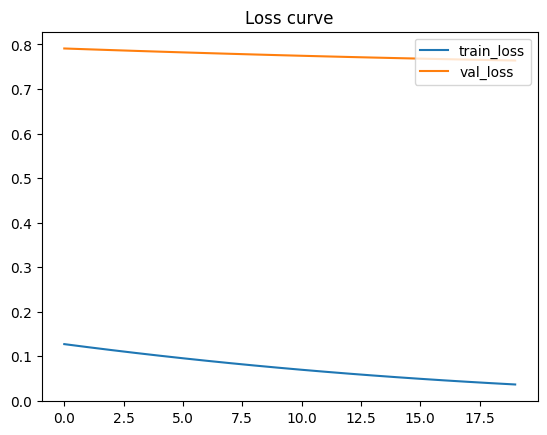

In [15]:
# train the model
train_losses = []
val_losses = []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = []
    val_loss = []
    print(f'Epoch {epoch}:')
    ckpt.epoch.assign_add(1)

    # training
    for data in tqdm(dataset_train, desc='Training'):
        loss = model.train_step(data)
        train_loss.append(loss.numpy())

    # validating
    for data in tqdm(dataset_val, desc='Validating'):
        loss = model.val_step(data)
        val_loss.append(loss.numpy())

    # record losses
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f}\n')
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))  

# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()

### Testing

In [16]:
# Initialize the testing environment
test_env = TestingEnvironment()
scores = []

# The item_ids here is for the random recommender
item_ids = [i for i in range(N_ITEMS)]

# Repeat the testing process for 5 times
for _ in range(TEST_EPISODES):
    # [TODO] Load your model weights here (in the beginning of each testing episode)
    # [TODO] Code for loading your model weights...
    ckpt.restore(manager.latest_checkpoint)

    # Start the testing process
    with tqdm(desc='Testing') as pbar:
        # Run as long as there exist some active users
        while test_env.has_next_state():
            # Get the current user id
            cur_user = test_env.get_state()
            
            # [TODO] Employ your recommendation policy to generate a slate of 5 distinct items
            # [TODO] Code for generating the recommended slate...
            slate = model.eval_predict_onestep(cur_user)

            # Get the response of the slate from the environment
            clicked_id, in_environment = test_env.get_response(slate)

            # [TODO] Update your model here (optional)
            # [TODO] You can update your model at each step, or perform a batched update after some interval
            # [TODO] Code for updating your model...
            ratings_data = []
            if clicked_id != -1:
                ratings_data.append({'user_id': cur_user, 'item_id': clicked_id, 'rating': 5.0})
            
            df = pd.DataFrame(ratings_data)
            df_ratings = pd.concat([df_ratings, df], ignore_index=True)
            
            # Update the progress indicator
            pbar.update(1)

    # Record the score of this testing episode
    scores.append(test_env.get_score())

    # Reset the testing environment
    test_env.reset()

    # [TODO] Delete or reset your model weights here (in the end of each testing episode)
    # [TODO] Code for deleting your model weights...
    ckpt.restore(manager.latest_checkpoint)
    df_ratings = df_ratings.drop_duplicates(subset=['user_id', 'item_id'], keep='first', ignore_index=True)

# Calculate the average scores 
avg_scores = [np.average(score) for score in zip(*scores)]

# Generate a DataFrame to output the result in a .csv file
df_result = pd.DataFrame([[user_id, avg_score] for user_id, avg_score in enumerate(avg_scores)], columns=['user_id', 'avg_score'])
df_result.to_csv(OUTPUT_PATH, index=False)
df_result

Testing: 3it [00:00, 24.24it/s]

Testing: 14215it [01:53, 124.83it/s]
Testing: 14198it [01:41, 140.20it/s]
Testing: 14209it [01:39, 142.10it/s]
Testing: 14195it [01:40, 141.75it/s]
Testing: 14222it [01:40, 141.96it/s]


,user_id,avg_score
0,0,0.0042
1,1,0.0043
2,2,0.0043
3,3,0.0047
4,4,0.0049
...,...,...
1995,1995,0.0025
1996,1996,0.0025
1997,1997,0.0025
1998,1998,0.0025


In [17]:
df_ratings = df_ratings.sort_values(by=['user_id', 'item_id'])
df_ratings

,user_id,item_id,rating
0,0.0,10162.0,5.0
1,0.0,13353.0,5.0
2,0.0,33127.0,5.0
3,0.0,35130.0,5.0
4,0.0,39676.0,5.0
...,...,...,...
164955,1998.0,55561.0,5.0
164956,1998.0,60372.0,5.0
164957,1999.0,77906.0,5.0
164958,1999.0,124792.0,5.0


In [18]:
mae = (df_result['avg_score'] - 1).abs().mean()
print(f"Mean Absolute Error (MAE): {mae:.6f}")

Mean Absolute Error (MAE): 0.996448


## Report
### I. Models have tried during the competition.
- **FunkSVD(from Recommender Systems Tutorial)**
    The Funk Singular Value Decomposition (FunkSVD) model is a matrix factorization technique particularly suited for recommender systems. Unlike traditional SVD, FunkSVD can handle sparse matrices, which are typical in user-item interaction data. We selected the FunkSVD model due to its efficiency in dealing with sparse data and its proven track record in collaborative filtering tasks. Its ability to capture latent factors in user-item interactions makes it adept at predicting user preferences, even with limited interaction history. 

- **Item-Based Collaborative Filtering(failed)**
    This model relies on the similarity between items to make recommendations. It constructs an item-item similarity matrix by computing the cosine similarity between item vectors in the user-item interaction matrix. Recommendations are then made based on items that are most similar to those the user has previously interacted with.Item-based collaborative filtering was chosen for its scalability and effectiveness in situations with fewer user interactions. We chose Item-Based Collaborative Filtering for its effectiveness in scenarios where user interactions are sparse and its inherent scalability when handling large user bases. This method appeared particularly suitable for our dataset, which had a higher item-to-user ratio. The primary challenge was the sheer volume of items in our dataset, which led to an excessively large item-item similarity matrix. This matrix size posed memory constraints, exceeding our available computational resources.

### II. List the experiments you have done.
- **FunkSVD**
    - Interaction Data Processing: Our initial approach involved using interaction data to determine whether a user clicked on an item. We assigned a high score (5.0) to items that were clicked and a low score (1.0) to those that weren't. This binary scoring method was the foundation of our early models.

    - Adapting to Dataset Limitations: Unlike datasets used in typical tutorials, where users have provided explicit ratings for the items they interact with, our competition dataset lacked such explicit user ratings. To address this, we self-assigned ratings to each interaction during the data collection phase from the test environment. This allowed us to simulate a scenario with explicit user preferences and enhance the effectiveness of our recommendation models.

    - Experiment with Soft Labels: In an attempt to refine our model's accuracy, we experimented with soft labels instead of binary scores. The idea was to incorporate varying degrees of preference rather than a strict clicked/unclicked dichotomy. However, due to time constraints and complexity in implementation, we reverted to using only clicked data (score 5.0) for our final submissions. Interestingly, we found that the performance did not significantly differ from the more nuanced approach.

    - Hyperparameter tuning: After rigorous experimentation, we found the following set of hyperparameters to yield the best performance: EMBEDDING_SIZE = 512, BATCH_SIZE = 128, N_EPOCHS = 20, LEARNING_RATE = 1e-5.

### III. Discussions
In this competition, the lack of substantial interaction data presented a significant challenge. Merely adjusting the model without considering other methods to potentially improve performance, or without collecting more data, made it difficult to achieve desirable results. The process of data augmentation also posed its own set of challenges; it wasn't just about recording which users clicked on which items, but also about designing a mechanism for user ratings. Despite collecting more interaction data from both the training and testing environments, making accurate recommendations for the latter 1,000 users during testing was particularly challenging due to the scarcity of data available from the training phase. This issue adversely affected our final ranking. Thus, how to ensure that all users receive good recommendations and how to effectively rate interactions based on user behavior remain critical questions for us to consider.
        